In [1]:
import numpy as np
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim

from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

In [2]:
df_brain_ct = pd.read_csv('/kaggle/input/computed-tomography-ct-of-the-brain/ct_brain.csv')

# EDA

In [3]:
df_brain_ct.head()

,dcm,jpg,type
0,/aneurysm/0.dcm,/aneurysm/0.jpg,aneurysm
1,/aneurysm/1.dcm,/aneurysm/1.jpg,aneurysm
2,/aneurysm/2.dcm,/aneurysm/2.jpg,aneurysm
3,/aneurysm/3.dcm,/aneurysm/3.jpg,aneurysm
4,/aneurysm/4.dcm,/aneurysm/4.jpg,aneurysm


In [4]:
image_dir = '/kaggle/input/computed-tomography-ct-of-the-brain/files'
def plot_images(df, count=1):
    """
    Plot images
    
    :param count: number of images to plot per category. ex: 1 = 1 of each
    """
    df_types = df.groupby('type').head(count)
    fig, axes = plt.subplots(count, 3, figsize=(10,5))
    axes = axes.flatten()

    for i, (index, row) in enumerate(df_types.iterrows()):
        brain_type = row['type']
        brain_image = Image.open(image_dir + row['jpg'])
        axes[i].imshow(brain_image)
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_title(brain_type)

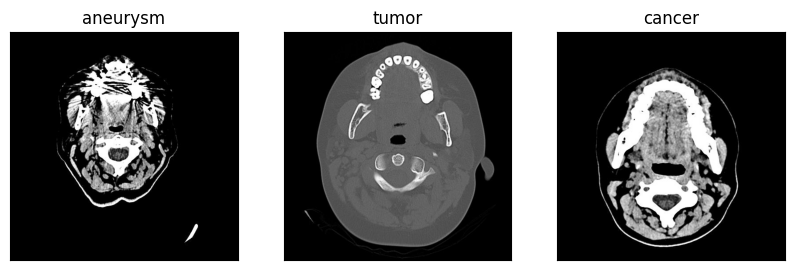

In [5]:
plot_images(df_brain_ct, 1)

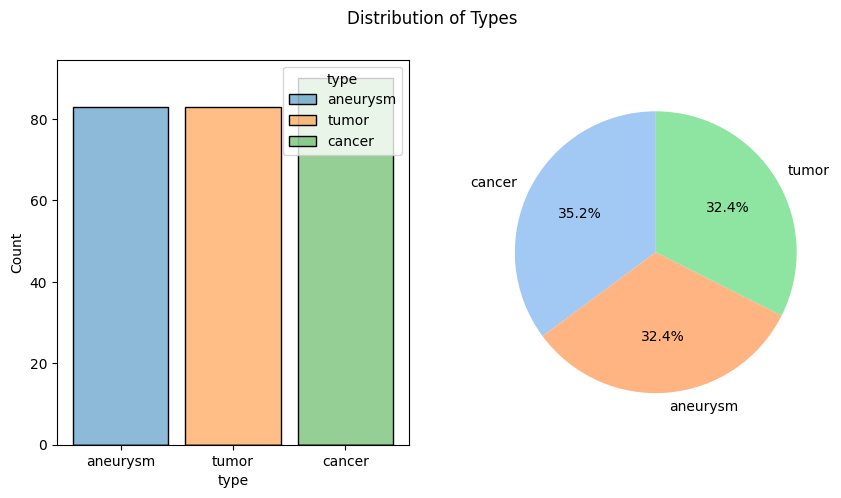

In [6]:
def plot_hist(df):
    colors = sns.color_palette('pastel')
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes = axes.flatten()
    
    sns.histplot(data=df, x='type', hue='type', shrink=.85, color=colors, ax=axes[0])
    
    type_counts = df['type'].value_counts()
    axes[1] = plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=90, colors = colors)
    
    fig.suptitle('Distribution of Types')
    plt.show()
    
plot_hist(df_brain_ct)

# Keras Implementation

In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Flatten, Conv2D

In [8]:
features = []
y = []
for i, row in df_brain_ct.iterrows():
    image = load_img(image_dir + row['jpg'])
    image = img_to_array(image)
    
    features.append(image)
    y.append(row['type'])

In [9]:
le = LabelEncoder()

X = np.array(features)
y = le.fit_transform(y)
y = np.array(y)
y = to_categorical(y)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [25]:
model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3), activation='relu', input_shape=(512,512,3)))
model.add(Flatten())
model.add(Dense(64, activation='relu', input_shape=(512,512)))
model.add(Dense(3, activation='softmax'))
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# fitting our model 
model.fit(X_train, y_train, epochs=10)

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 32)      896       
                                                                 
 flatten (Flatten)           (None, 8323200)           0         
                                                                 
 dense (Dense)               (None, 64)                532684864 
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 532,685,955
Trainable params: 532,685,955
Non-trainable params: 0
_________________________________________________________________


In [61]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 4s 1s/step - loss: 211.4897 - accuracy: 0.9844


[211.48971557617188, 0.984375]

# Pytorch Implementation

In [11]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available.")
else:
    device = torch.device("cpu")
    print("GPU is not available.")

GPU is not available.


In [12]:
from torchvision import transforms

label_encoder = LabelEncoder()
df_brain_ct['label'] = label_encoder.fit_transform(df_brain_ct['type'])

class BrainDataset(torch.utils.data.Dataset):
    def __init__(self, df, img_path, img_size):
        self.df = df
        self.img_path = img_path
        self.img_size = img_size
        self.transforms = transforms.Compose([
            transforms.Resize(img_size),
            transforms.CenterCrop(img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        brain_type = row['label']
        image_path = row['jpg']
        img = Image.open(self.img_path + image_path).convert('RGB')
        image = self.transforms(img)
        return image, brain_type

In [13]:
train, test = train_test_split(df_brain_ct, test_size=0.2, stratify=df_brain_ct['type'], random_state=42)
val, test = train_test_split(test, test_size=0.2, stratify=test['type'], random_state=42)

In [14]:
ds_train = BrainDataset(train, image_dir, (512, 512))
ds_val = BrainDataset(val, image_dir, (512, 512))
ds_test = BrainDataset(test, image_dir, (512, 512))

train_data_loader = torch.utils.data.DataLoader(ds_train, batch_size=32, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(ds_val, batch_size=32, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(ds_test, batch_size=32, shuffle=True)

In [15]:
from torch import nn
import torch.nn.functional as F

In [16]:
class BrainModel(nn.Module):
    def __init__(self):
        super(BrainModel2, self).__init__()
        
        self.pool = nn.MaxPool2d(2, 2)
        self.avgpool = nn.AvgPool2d(2, 2)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            self.pool,
        ) 
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            self.pool,
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            self.pool, 
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            self.pool,
        )
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            self.pool,
        )
        
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            self.pool,
        )
        
        self.fc = nn.Sequential(
            nn.Linear(256 * 6 * 6, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 3)
        )
        
    def forward(self, x):
        batch_size = x.size(0)
        
        x = self.conv(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = x.view(batch_size, -1)
        x = self.fc(x)
        return x

In [17]:
model_brain = BrainModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_brain.parameters())

In [32]:
def compute_metrics(actual, predicted, plot_cm=True):
    accuracy = accuracy_score(actual, predicted)
    precision = precision_score(actual, predicted, average='micro')  # or 'micro', 'weighted', or None
    recall = recall_score(actual, predicted, average='micro')  # or 'micro', 'weighted', or None
    f1 = f1_score(actual, predicted, average='micro')
    
    print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}')
    
    if plot_cm:
        cm = confusion_matrix(actual, predicted)
        plt.figure(figsize=(8, 6))
        ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

        # Convert xticks and yticks to text labels
        class_labels = label_encoder.inverse_transform(np.arange(len(cm)))
        ax.set_xticks(np.arange(len(class_labels)) + 0.5, minor=False)
        ax.set_yticks(np.arange(len(class_labels)) + 0.5, minor=False)
        ax.set_xticklabels(class_labels, rotation=45)
        ax.set_yticklabels(class_labels, rotation=0)

        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()

def training_loop(model, criterion, optimizer, train_loader, val_loader, epochs):
    train_losses = []
    train_accuracies = []
    
    val_losses = []
    val_accuracies = []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}")
        train_loss, train_accuracy = train(model, criterion, optimizer, train_loader)
        val_loss, val_accuracy = evaluate(model, criterion, val_loader)
        print()
        print("="*30)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        
    print("Total Metrics:")
    print(f"Training Loss: {sum(train_losses) / len(train_losses):.4f}, Average Training Accuracy: {sum(train_accuracies) / len(train_accuracies):.2f}")
    print(f"Validation Loss: {sum(val_losses) / len(val_losses):.4f}, Average Validation Accuracy: {sum(val_accuracies) / len(val_accuracies):.2f}")
        
def train(model, criterion, optimizer, loader):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    actuals = []
    predicteds = []
    for batch_idx, (inputs, labels) in enumerate(loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        
        actuals.extend(labels.cpu().numpy())
        predicteds.extend(predicted.cpu().numpy())
        
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

    accuracy = total_correct / total_samples
    print(f"Training Loss: {total_loss:.4f}, Accuracy: {accuracy:.2f}")
    compute_metrics(actuals, predicteds, False)
    
    return total_loss / len(loader), accuracy
    
def evaluate(model, criterion, loader):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    actuals = []
    predicteds = []
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            actuals.extend(labels.cpu().numpy())
            predicteds.extend(predicted.cpu().numpy())
            
    accuracy = total_correct / total_samples
    print(f"Validation Loss: {total_loss:.4f}, Accuracy: {accuracy:.2f}")
    compute_metrics(actuals, predicteds)
    return total_loss / len(loader), accuracy

Epoch 1
Training Loss: 0.1648, Accuracy: 0.99
Accuracy: 0.9852941176470589, Precision: 0.9852941176470589, Recall: 0.9852941176470589, F1-Score: 0.9852941176470589
Validation Loss: 0.1289, Accuracy: 0.98
Accuracy: 0.975609756097561, Precision: 0.975609756097561, Recall: 0.975609756097561, F1-Score: 0.975609756097561


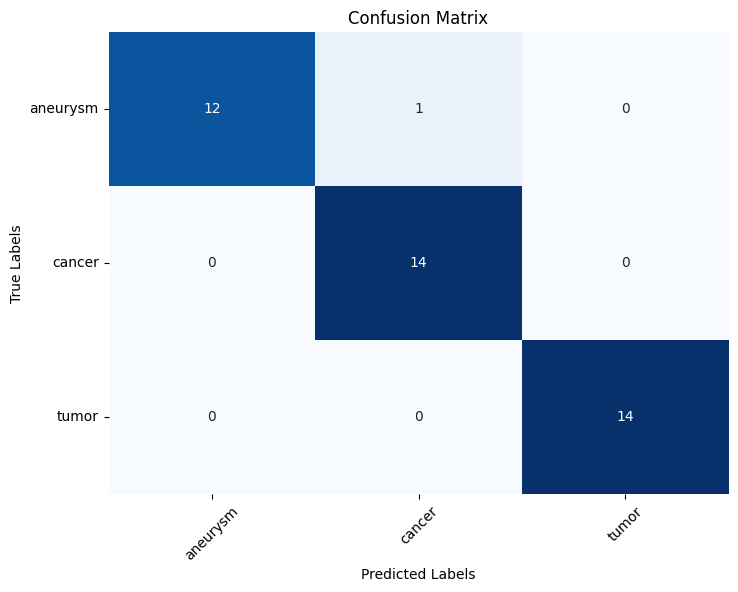


Epoch 2
Training Loss: 0.2117, Accuracy: 0.99
Accuracy: 0.9852941176470589, Precision: 0.9852941176470589, Recall: 0.9852941176470589, F1-Score: 0.9852941176470589
Validation Loss: 0.1409, Accuracy: 0.98
Accuracy: 0.975609756097561, Precision: 0.975609756097561, Recall: 0.975609756097561, F1-Score: 0.975609756097561


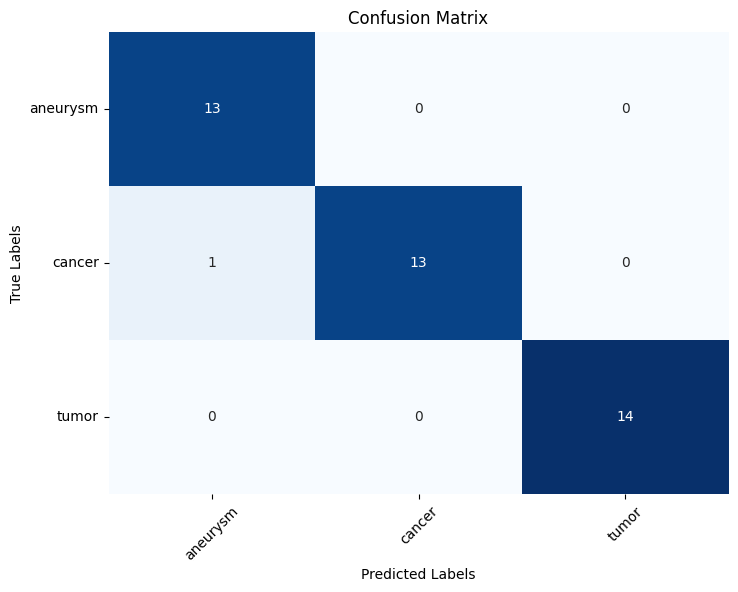


Epoch 3
Training Loss: 0.2645, Accuracy: 0.99
Accuracy: 0.9901960784313726, Precision: 0.9901960784313726, Recall: 0.9901960784313726, F1-Score: 0.9901960784313726
Validation Loss: 0.1529, Accuracy: 0.98
Accuracy: 0.975609756097561, Precision: 0.975609756097561, Recall: 0.975609756097561, F1-Score: 0.975609756097561


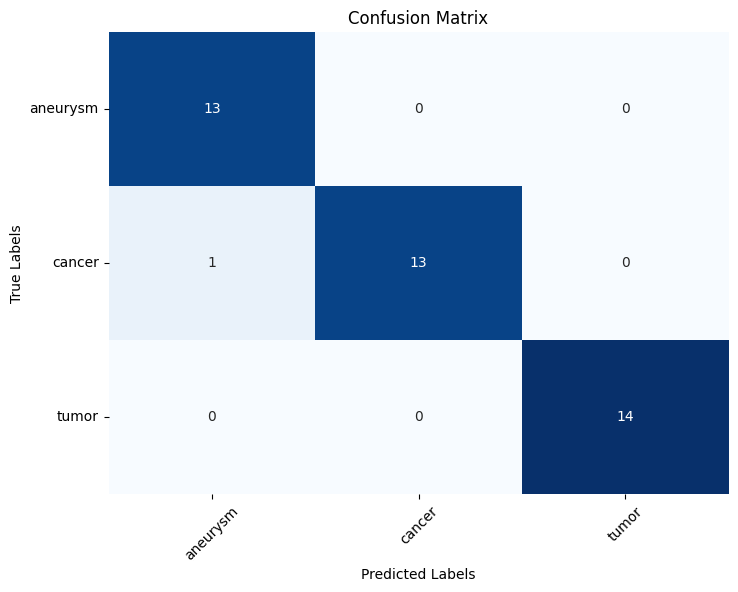


Epoch 4
Training Loss: 0.5621, Accuracy: 0.99
Accuracy: 0.9901960784313726, Precision: 0.9901960784313726, Recall: 0.9901960784313726, F1-Score: 0.9901960784313726
Validation Loss: 0.0850, Accuracy: 0.98
Accuracy: 0.975609756097561, Precision: 0.975609756097561, Recall: 0.975609756097561, F1-Score: 0.975609756097561


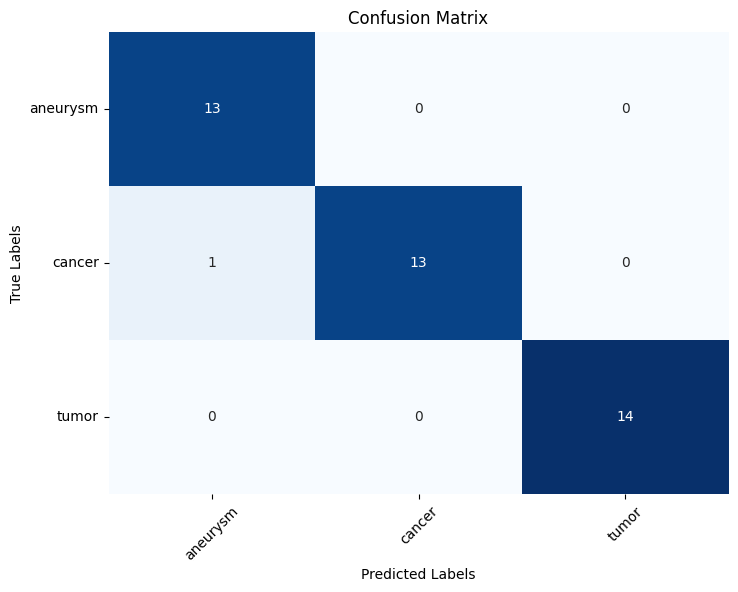


Epoch 5
Training Loss: 0.2178, Accuracy: 0.98
Accuracy: 0.9803921568627451, Precision: 0.9803921568627451, Recall: 0.9803921568627451, F1-Score: 0.9803921568627451
Validation Loss: 0.0979, Accuracy: 0.98
Accuracy: 0.975609756097561, Precision: 0.975609756097561, Recall: 0.975609756097561, F1-Score: 0.975609756097561


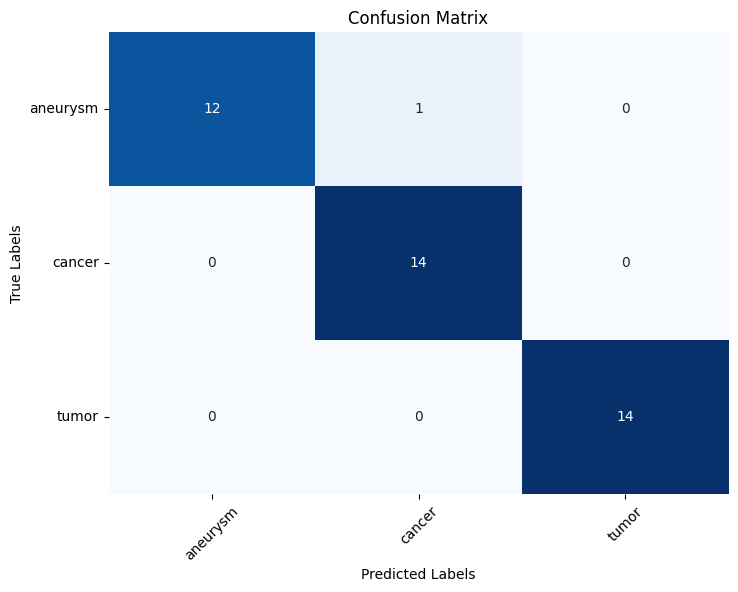


Epoch 6
Training Loss: 0.7923, Accuracy: 0.98
Accuracy: 0.9803921568627451, Precision: 0.9803921568627451, Recall: 0.9803921568627451, F1-Score: 0.9803921568627451
Validation Loss: 0.1636, Accuracy: 0.98
Accuracy: 0.975609756097561, Precision: 0.975609756097561, Recall: 0.975609756097561, F1-Score: 0.975609756097561


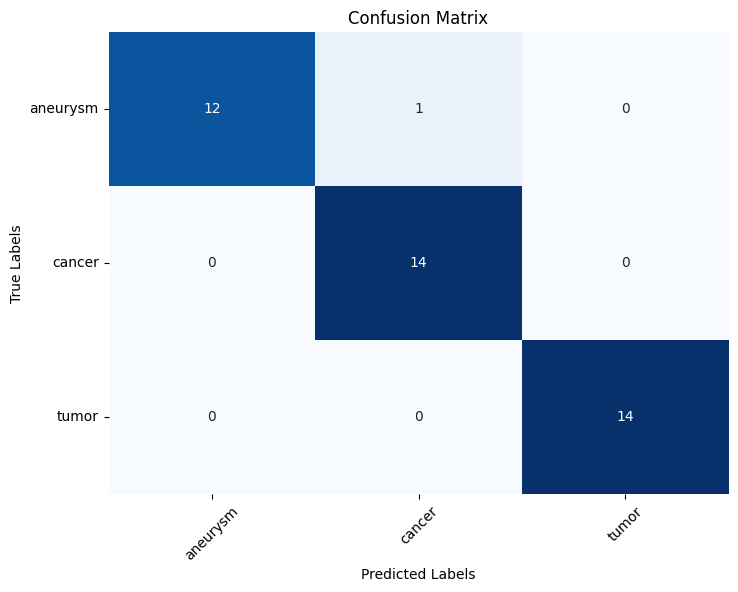


Epoch 7
Training Loss: 0.1390, Accuracy: 0.99
Accuracy: 0.9901960784313726, Precision: 0.9901960784313726, Recall: 0.9901960784313726, F1-Score: 0.9901960784313726
Validation Loss: 0.1494, Accuracy: 0.98
Accuracy: 0.975609756097561, Precision: 0.975609756097561, Recall: 0.975609756097561, F1-Score: 0.975609756097561


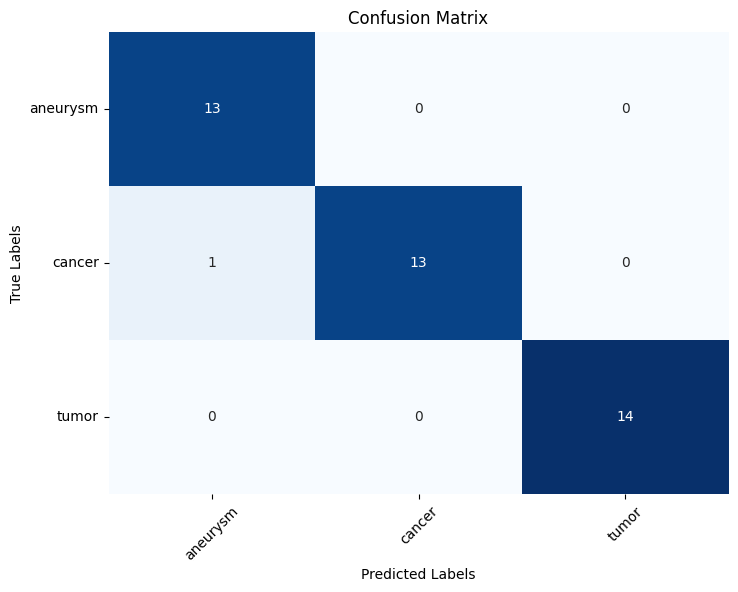


Epoch 8
Training Loss: 0.3508, Accuracy: 0.99
Accuracy: 0.9852941176470589, Precision: 0.9852941176470589, Recall: 0.9852941176470589, F1-Score: 0.9852941176470589
Validation Loss: 0.5246, Accuracy: 0.98
Accuracy: 0.975609756097561, Precision: 0.975609756097561, Recall: 0.975609756097561, F1-Score: 0.975609756097561


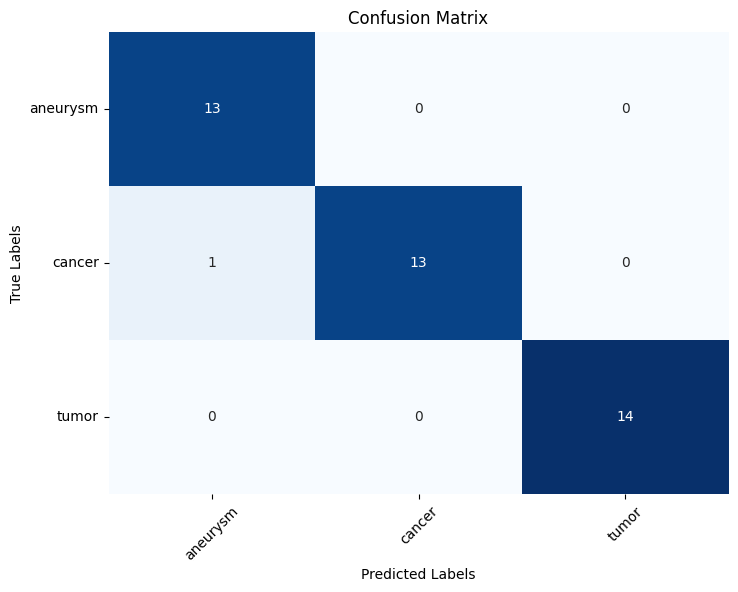


Epoch 9
Training Loss: 0.2300, Accuracy: 0.99
Accuracy: 0.9901960784313726, Precision: 0.9901960784313726, Recall: 0.9901960784313726, F1-Score: 0.9901960784313726
Validation Loss: 0.1171, Accuracy: 0.98
Accuracy: 0.975609756097561, Precision: 0.975609756097561, Recall: 0.975609756097561, F1-Score: 0.975609756097561


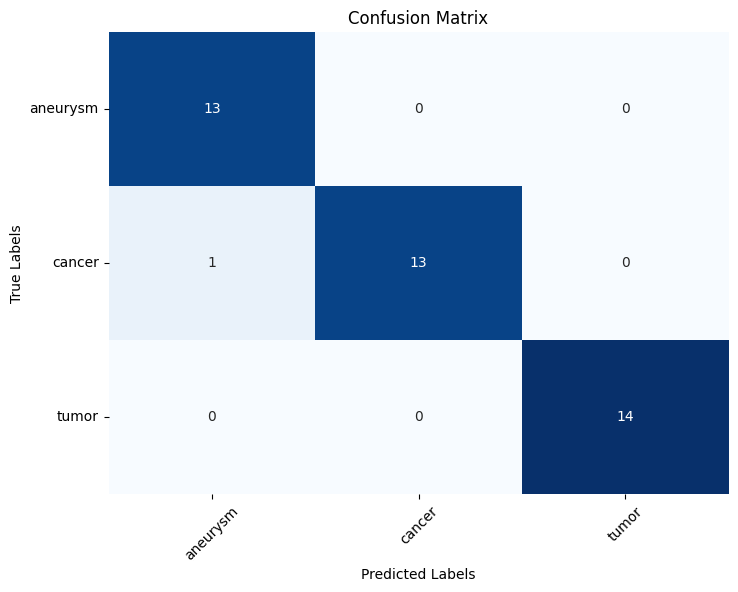


Epoch 10
Training Loss: 0.2168, Accuracy: 0.99
Accuracy: 0.9901960784313726, Precision: 0.9901960784313726, Recall: 0.9901960784313726, F1-Score: 0.9901960784313726
Validation Loss: 0.0683, Accuracy: 0.98
Accuracy: 0.975609756097561, Precision: 0.975609756097561, Recall: 0.975609756097561, F1-Score: 0.975609756097561


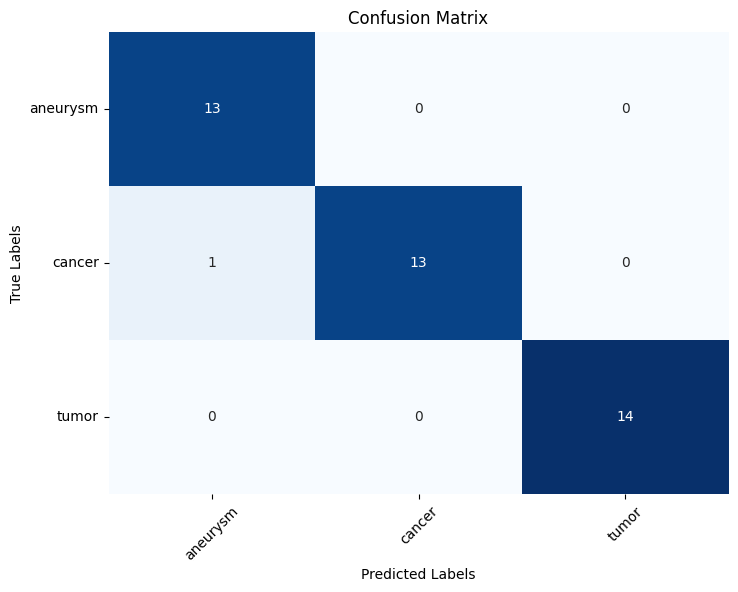


Total Metrics:
Training Loss: 0.0450, Average Training Accuracy: 0.99
Validation Loss: 0.0814, Average Validation Accuracy: 0.98


In [33]:
training_loop(model_brain, criterion, optimizer, train_data_loader, val_data_loader, 10)

In [31]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [32]:
from torchsummary import summary

summary(model_brain, input_size=(3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 510, 510]             896
       BatchNorm2d-2         [-1, 32, 510, 510]              64
              ReLU-3         [-1, 32, 510, 510]               0
         MaxPool2d-4         [-1, 32, 255, 255]               0
         MaxPool2d-5         [-1, 32, 255, 255]               0
         MaxPool2d-6         [-1, 32, 255, 255]               0
         MaxPool2d-7         [-1, 32, 255, 255]               0
         MaxPool2d-8         [-1, 32, 255, 255]               0
         MaxPool2d-9         [-1, 32, 255, 255]               0
        MaxPool2d-10         [-1, 32, 255, 255]               0
           Conv2d-11         [-1, 64, 253, 253]          18,496
      BatchNorm2d-12         [-1, 64, 253, 253]             128
             ReLU-13         [-1, 64, 253, 253]               0
        MaxPool2d-14         [-1, 64, 1

In [34]:
def predict(model, loader):
    model.eval()
    
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    actuals = []
    predicteds = []
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            actuals.extend(labels.cpu().numpy())
            predicteds.extend(predicted.cpu().numpy())
            
    accuracy = total_correct / total_samples
    print(f"Test Loss: {total_loss:.4f}, Accuracy: {accuracy:.2f}")
    compute_metrics(actuals, predicteds)
    
    # Predicted vs actual with pictures
    fig, axes = plt.subplots(1, 5, figsize=(15,20))
    axes = axes.flatten()
    for i, res in enumerate(outputs[:5]):
        predicted_label = label_encoder.inverse_transform([predicted[i]])[0]
        actual_label = label_encoder.inverse_transform([labels[i]])[0]
        axes[i].imshow(np.transpose(inputs[i].numpy(), (1, 2, 0)))
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_title(f"Predicted: {predicted_label} \n Actual: {actual_label}")
    
    plt.show()


Test Loss: 0.0024, Accuracy: 1.00
Accuracy: 1.0, Precision: 1.0, Recall: 1.0, F1-Score: 1.0


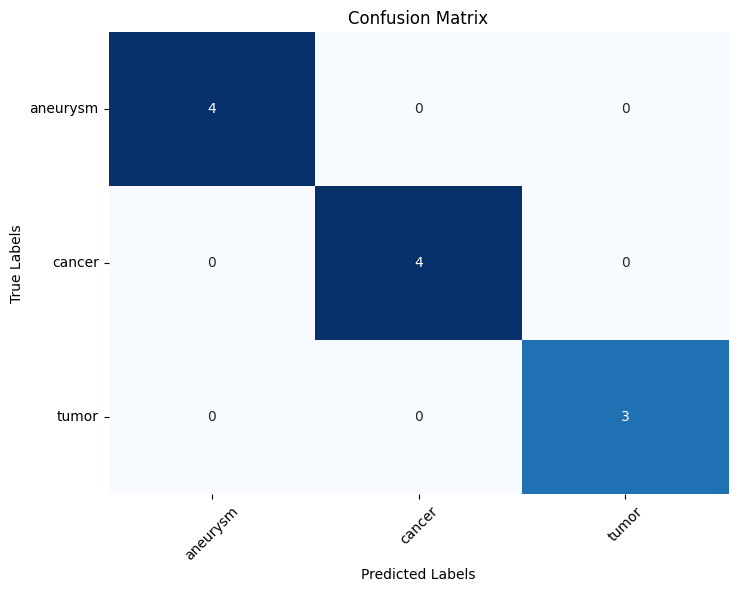

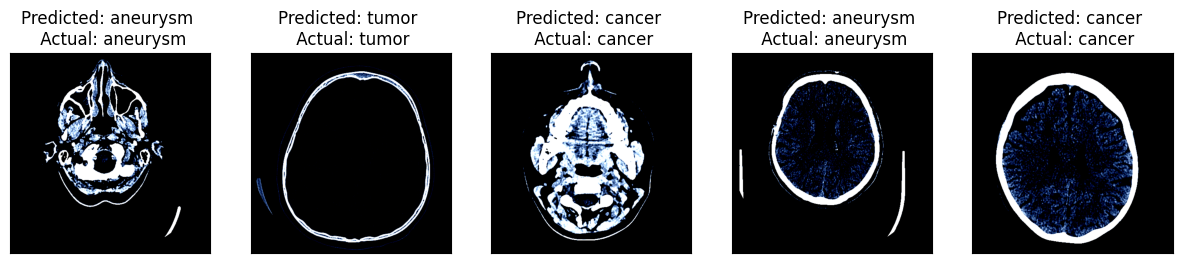

In [35]:
predict(model_brain, test_data_loader)

In [43]:
import requests
from io import BytesIO

image_url = 'https://img.medscapestatic.com/pi/meds/ckb/34/15034tn.jpg'
response = requests.get(image_url)
image = Image.open(BytesIO(response.content))

im = ds_test.transforms(image)
im = im.unsqueeze(0)

In [37]:
output = model_brain(im)
_, predicted = torch.max(output, 1)
print(predicted.shape)
predicted_label = label_encoder.inverse_transform(predicted)
predicted_label[0]

torch.Size([1])


'tumor'

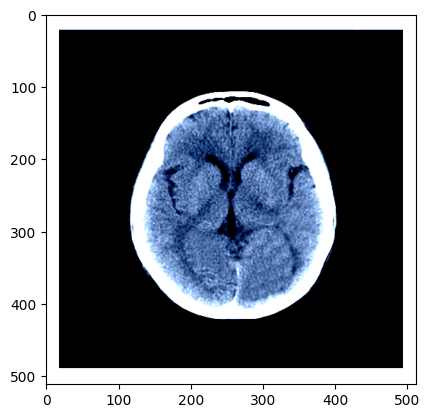

In [81]:
plt.imshow(np.transpose(im.squeeze().numpy(), (1, 2, 0)))